# 🧘 SuryaNet v3.0 - REAL Ablation Study

This notebook runs **ACTUAL** ablation experiments by training separate model variants:

| # | Configuration | What's Changed |
|---|--------------|----------------|
| 1 | **Full Model** | ViT + GCN + Cross-Modal + Contrastive (Baseline) |
| 2 | Without Contrastive | Remove contrastive learning loss |
| 3 | Without Cross-Modal | Replace cross-modal transformer with concatenation |
| 4 | Without GCN | Replace GCN with flattened MLP |
| 5 | ResNet instead of ViT | Replace ViT backbone with ResNet-18 |
| 6 | Visual Only | Remove skeleton branch entirely |
| 7 | Skeleton Only | Remove visual branch entirely |

⏱️ **Estimated Time**: 2-4 hours on T4 GPU

⚠️ **Important**: Make sure GPU is enabled: Runtime → Change runtime type → T4 GPU

In [1]:
#@title 1️⃣ Environment Setup
print("="*60)
print("[1/10] Setting up environment...")
print("="*60)

# Install all required packages first
!pip install -q pandas numpy matplotlib seaborn tqdm pillow opencv-python-headless
!pip install -q torch torchvision
!pip install -q timm wandb opendatasets mediapipe scikit-learn

import os
import sys
import json
import random
import warnings
import time
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import timm
import wandb

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

[1/10] Setting up environment...

✅ Using device: cuda
   GPU: NVIDIA GeForce RTX 5090
   Memory: 33.7 GB


In [2]:
#@title 2️⃣ Configuration
print("\n" + "="*60)
print("[2/10] Setting up configuration...")
print("="*60)

class Config:
    """Configuration for SuryaNet v3 Ablation Study"""
    EXPERIMENT_NAME = f"SuryaNet-v3-Ablation-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    WANDB_PROJECT = "suryanet-ablation-study"

    # Dataset
    POSE_CLASSES = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
    NUM_CLASSES = 5
    IMG_SIZE = 224
    NUM_KEYPOINTS = 33

    # Skeleton graph edges (MediaPipe 33 keypoints)
    SKELETON_EDGES = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
        (9, 10), (11, 12), (11, 23), (12, 24), (23, 24),
        (11, 13), (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
        (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20),
        (23, 25), (25, 27), (27, 29), (27, 31), (29, 31),
        (24, 26), (26, 28), (28, 30), (28, 32), (30, 32),
    ]

    # Model architecture
    VIT_MODEL = 'vit_base_patch16_224'
    VIT_FEATURE_DIM = 768
    GCN_HIDDEN_DIM = 128
    GCN_OUTPUT_DIM = 256
    FUSION_DIM = 512
    NUM_ATTENTION_HEADS = 8
    NUM_TRANSFORMER_LAYERS = 2
    DROPOUT = 0.3

    # Training - optimized for ablation study
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.05
    NUM_EPOCHS = 15  # Reduced for ablation; use 50 for final model
    PATIENCE = 5
    WARMUP_EPOCHS = 3

    # Contrastive learning
    CONTRASTIVE_TEMPERATURE = 0.07
    QUALITY_MARGIN = 0.1

    # Directories
    BASE_DIR = Path("/content")
    DATA_DIR = BASE_DIR / "data"
    RESULTS_DIR = BASE_DIR / "ablation_results"
    MODELS_DIR = BASE_DIR / "ablation_models"
    FIGURES_DIR = BASE_DIR / "ablation_figures"

    @classmethod
    def create_dirs(cls):
        for d in [cls.DATA_DIR, cls.RESULTS_DIR, cls.MODELS_DIR, cls.FIGURES_DIR]:
            d.mkdir(parents=True, exist_ok=True)

Config.create_dirs()
print(f"\n✅ Configuration ready!")
print(f"   Experiment: {Config.EXPERIMENT_NAME}")
print(f"   Epochs per model: {Config.NUM_EPOCHS}")
print(f"   Batch size: {Config.BATCH_SIZE}")


[2/10] Setting up configuration...

✅ Configuration ready!
   Experiment: SuryaNet-v3-Ablation-20251231-083701
   Epochs per model: 15
   Batch size: 16


In [3]:
#@title 3️⃣ MediaPipe Setup & Keypoint Extraction
print("\n" + "="*60)
print("[3/10] Setting up keypoint extraction...")
print("="*60)

# Reinstall mediapipe to ensure correct version
!pip uninstall -q -y mediapipe
!pip install -q mediapipe==0.10.14

# Try to initialize MediaPipe
MEDIAPIPE_AVAILABLE = False
pose_detector = None

try:
    import mediapipe as mp
    mp_pose = mp.solutions.pose
    pose_detector = mp_pose.Pose(static_image_mode=True, model_complexity=2, min_detection_confidence=0.5)
    MEDIAPIPE_AVAILABLE = True
    print("✅ MediaPipe initialized successfully!")
except Exception as e:
    print(f"⚠️ MediaPipe not available: {e}")
    print("   Will use heuristic keypoint estimation")


def extract_keypoints_mediapipe(image_np):
    """Extract keypoints using MediaPipe"""
    try:
        if len(image_np.shape) == 3 and image_np.shape[2] == 3:
            image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = image_np
        results = pose_detector.process(image_rgb)
        if results.pose_landmarks:
            keypoints = np.array([
                [lm.x, lm.y, lm.z, lm.visibility]
                for lm in results.pose_landmarks.landmark
            ])
            return keypoints
    except:
        pass
    return None


def extract_keypoints_heuristic(image_np):
    """Fallback heuristic keypoint extraction"""
    try:
        if len(image_np.shape) == 3:
            gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
        else:
            gray = image_np
        gray = cv2.resize(gray, (224, 224))
        edges = cv2.Canny(gray, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest)
            M = cv2.moments(largest)
            cx = M["m10"] / (M["m00"] + 1e-6) / 224
            cy = M["m01"] / (M["m00"] + 1e-6) / 224

            keypoints = np.zeros((33, 4))
            x_n, y_n, w_n, h_n = x/224, y/224, w/224, h/224

            # Approximate keypoint positions
            keypoints[0] = [cx, y_n + 0.05*h_n, 0, 0.8]  # nose
            keypoints[11] = [cx - 0.15*w_n, y_n + 0.2*h_n, 0, 0.7]  # left shoulder
            keypoints[12] = [cx + 0.15*w_n, y_n + 0.2*h_n, 0, 0.7]  # right shoulder
            keypoints[13] = [cx - 0.2*w_n, y_n + 0.35*h_n, 0, 0.6]  # left elbow
            keypoints[14] = [cx + 0.2*w_n, y_n + 0.35*h_n, 0, 0.6]  # right elbow
            keypoints[15] = [cx - 0.25*w_n, y_n + 0.5*h_n, 0, 0.5]  # left wrist
            keypoints[16] = [cx + 0.25*w_n, y_n + 0.5*h_n, 0, 0.5]  # right wrist
            keypoints[23] = [cx - 0.1*w_n, y_n + 0.55*h_n, 0, 0.7]  # left hip
            keypoints[24] = [cx + 0.1*w_n, y_n + 0.55*h_n, 0, 0.7]  # right hip
            keypoints[25] = [cx - 0.1*w_n, y_n + 0.75*h_n, 0, 0.6]  # left knee
            keypoints[26] = [cx + 0.1*w_n, y_n + 0.75*h_n, 0, 0.6]  # right knee
            keypoints[27] = [cx - 0.1*w_n, y_n + 0.95*h_n, 0, 0.5]  # left ankle
            keypoints[28] = [cx + 0.1*w_n, y_n + 0.95*h_n, 0, 0.5]  # right ankle

            return keypoints
    except:
        pass
    return np.random.randn(33, 4) * 0.1 + 0.5


def extract_keypoints(image_np):
    """Extract keypoints with fallback"""
    if MEDIAPIPE_AVAILABLE:
        kp = extract_keypoints_mediapipe(image_np)
        if kp is not None:
            return kp
    return extract_keypoints_heuristic(image_np)


def compute_quality_score(keypoints, pose_class):
    """Compute quality score from keypoints"""
    if keypoints is None:
        return 0.5

    # Visibility-based score
    visibility_score = np.mean(keypoints[:, 3])

    # Symmetry score
    pairs = [(11, 12), (23, 24), (25, 26), (27, 28)]
    asymmetry = []
    for l, r in pairs:
        asymmetry.append(abs(keypoints[l, 1] - keypoints[r, 1]))
    symmetry_score = 1 - np.mean(asymmetry)

    # Combined score
    quality = 0.6 * visibility_score + 0.4 * symmetry_score
    quality = np.clip(quality + np.random.normal(0, 0.05), 0.2, 0.95)

    return float(quality)

print("✅ Keypoint extraction ready!")


[3/10] Setting up keypoint extraction...


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ MediaPipe initialized successfully!
✅ Keypoint extraction ready!


I0000 00:00:1767170242.946574   11196 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1767170243.330409   11518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.153.02), renderer: NVIDIA GeForce RTX 5090/PCIe/SSE2


In [4]:
#@title 4️⃣ Model Components (GCN, ViT, Fusion, etc.)
print("\n" + "="*60)
print("[4/10] Building model components...")
print("="*60)

# ============== GRAPH CONVOLUTIONAL NETWORK ==============
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features)) if bias else None
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        support = torch.matmul(x, self.weight)
        output = torch.matmul(adj, support)
        return output + self.bias if self.bias is not None else output


class AdaptiveGraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, num_nodes):
        super().__init__()
        self.gcn = GraphConvolution(in_features, out_features)
        self.adaptive_adj = nn.Parameter(torch.randn(num_nodes, num_nodes) * 0.01)

    def forward(self, x, fixed_adj):
        adaptive = torch.softmax(self.adaptive_adj, dim=-1)
        combined_adj = 0.7 * fixed_adj + 0.3 * adaptive
        return self.gcn(x, combined_adj)


class SpatialTemporalGCN(nn.Module):
    """GCN for skeleton feature extraction"""
    def __init__(self, num_joints=33, in_channels=4, hidden_channels=128, out_channels=256):
        super().__init__()
        self.num_joints = num_joints
        self.register_buffer('adj', self._build_adjacency(Config.SKELETON_EDGES))

        self.gcn1 = AdaptiveGraphConvolution(in_channels, hidden_channels, num_joints)
        self.bn1 = nn.BatchNorm1d(num_joints)
        self.gcn2 = AdaptiveGraphConvolution(hidden_channels, hidden_channels, num_joints)
        self.bn2 = nn.BatchNorm1d(num_joints)
        self.gcn3 = AdaptiveGraphConvolution(hidden_channels, out_channels, num_joints)
        self.bn3 = nn.BatchNorm1d(num_joints)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.output_proj = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.LayerNorm(out_channels),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.dropout = nn.Dropout(0.1)

    def _build_adjacency(self, edges):
        adj = torch.zeros(self.num_joints, self.num_joints)
        for i, j in edges:
            if i < self.num_joints and j < self.num_joints:
                adj[i, j] = 1
                adj[j, i] = 1
        adj = adj + torch.eye(self.num_joints)
        degree = adj.sum(dim=1, keepdim=True)
        return adj / (degree + 1e-6)

    def forward(self, keypoints):
        x = F.gelu(self.dropout(self.bn1(self.gcn1(keypoints, self.adj))))
        x = F.gelu(self.dropout(self.bn2(self.gcn2(x, self.adj))))
        x = F.gelu(self.bn3(self.gcn3(x, self.adj)))
        x = self.global_pool(x.transpose(1, 2)).squeeze(-1)
        return self.output_proj(x)


# ============== FLATTENED MLP (Ablation: No GCN) ==============
class FlattenedKeypointMLP(nn.Module):
    """Simple MLP for flattened keypoints - no graph structure"""
    def __init__(self, num_keypoints=33, in_channels=4, out_channels=256):
        super().__init__()
        input_dim = num_keypoints * in_channels
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(256, 256), nn.BatchNorm1d(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, out_channels), nn.LayerNorm(out_channels), nn.GELU()
        )

    def forward(self, keypoints):
        return self.mlp(keypoints.view(keypoints.size(0), -1))


# ============== VISION TRANSFORMER ==============
class ViTFeatureExtractor(nn.Module):
    """ViT backbone for visual features"""
    def __init__(self, model_name='vit_base_patch16_224', pretrained=True, output_dim=768, freeze_layers=6):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

        if freeze_layers > 0:
            for i, block in enumerate(self.vit.blocks):
                if i < freeze_layers:
                    for param in block.parameters():
                        param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(self.vit.embed_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.GELU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.vit.patch_embed(x)
        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.vit.pos_embed
        x = self.vit.pos_drop(x)
        for block in self.vit.blocks:
            x = block(x)
        x = self.vit.norm(x)
        return self.projection(x[:, 0])


# ============== RESNET-18 (Ablation: Replace ViT) ==============
class ResNetFeatureExtractor(nn.Module):
    """ResNet-18 backbone - ablation variant"""
    def __init__(self, output_dim=768, pretrained=True):
        super().__init__()
        resnet = models.resnet18(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection = nn.Sequential(
            nn.Linear(512, output_dim),
            nn.LayerNorm(output_dim),
            nn.GELU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.backbone(x).view(x.size(0), -1)
        return self.projection(x)


# ============== CROSS-MODAL TRANSFORMER FUSION ==============
class CrossModalAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, query, key_value):
        B = query.size(0)
        q = self.q_proj(query).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key_value).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(key_value).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.dropout(F.softmax(attn, dim=-1))
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, -1, self.num_heads * self.head_dim)
        return self.norm(query + self.out_proj(out))


class CrossModalTransformerFusion(nn.Module):
    """Bidirectional cross-modal transformer fusion"""
    def __init__(self, visual_dim=768, skeleton_dim=256, fusion_dim=512, num_heads=8, num_layers=2, dropout=0.1):
        super().__init__()
        self.visual_proj = nn.Linear(visual_dim, fusion_dim)
        self.skeleton_proj = nn.Linear(skeleton_dim, fusion_dim)

        self.v2s_layers = nn.ModuleList([CrossModalAttention(fusion_dim, num_heads, dropout) for _ in range(num_layers)])
        self.s2v_layers = nn.ModuleList([CrossModalAttention(fusion_dim, num_heads, dropout) for _ in range(num_layers)])

        self.gate = nn.Sequential(nn.Linear(fusion_dim * 2, fusion_dim), nn.Sigmoid())
        self.output_proj = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.LayerNorm(fusion_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.modality_weights = nn.Parameter(torch.ones(2) * 0.5)

    def forward(self, visual_features, skeleton_features):
        v = self.visual_proj(visual_features).unsqueeze(1)
        s = self.skeleton_proj(skeleton_features).unsqueeze(1)

        for v2s, s2v in zip(self.v2s_layers, self.s2v_layers):
            v, s = v2s(v, s), s2v(s, v)

        v, s = v.squeeze(1), s.squeeze(1)
        concat = torch.cat([v, s], dim=-1)
        gate = self.gate(concat)
        weights = F.softmax(self.modality_weights, dim=0)
        fused = torch.cat([weights[0] * v * gate, weights[1] * s * (1 - gate)], dim=-1)
        return self.output_proj(fused)


# ============== SIMPLE CONCATENATION (Ablation: No Cross-Modal) ==============
class ConcatenationFusion(nn.Module):
    """Simple concatenation fusion - no cross-modal attention"""
    def __init__(self, visual_dim=768, skeleton_dim=256, fusion_dim=512, dropout=0.1):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(visual_dim + skeleton_dim, fusion_dim),
            nn.LayerNorm(fusion_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(fusion_dim, fusion_dim),
            nn.LayerNorm(fusion_dim), nn.GELU()
        )

    def forward(self, visual_features, skeleton_features):
        return self.fusion(torch.cat([visual_features, skeleton_features], dim=-1))


# ============== CONTRASTIVE LOSS ==============
class ContrastiveQualityLoss(nn.Module):
    def __init__(self, temperature=0.07, margin=0.1):
        super().__init__()
        self.temperature = temperature
        self.margin = margin

    def forward(self, features, quality_scores):
        if features.size(0) < 2:
            return torch.tensor(0.0, device=features.device)

        features = F.normalize(features, dim=1)
        similarity = torch.matmul(features, features.T) / self.temperature
        quality_diff = torch.abs(quality_scores.unsqueeze(1) - quality_scores.unsqueeze(0))

        positive_mask = (quality_diff < self.margin).float()
        positive_mask.fill_diagonal_(0)
        negative_mask = (quality_diff >= self.margin).float()

        if positive_mask.sum() == 0:
            return torch.tensor(0.0, device=features.device)

        exp_sim = torch.exp(similarity)
        pos_sim = (exp_sim * positive_mask).sum(dim=1)
        neg_sim = (exp_sim * negative_mask).sum(dim=1)

        loss = -torch.log(pos_sim / (pos_sim + neg_sim + 1e-8) + 1e-8)
        valid_mask = positive_mask.sum(dim=1) > 0
        return loss[valid_mask].mean() if valid_mask.sum() > 0 else torch.tensor(0.0, device=features.device)

print("✅ All model components built!")


[4/10] Building model components...
✅ All model components built!


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
#@title 5️⃣ Define All Ablation Model Variants
print("\n" + "="*60)
print("[5/10] Defining ablation model variants...")
print("="*60)

def create_prediction_heads(fusion_dim=512, num_classes=5, dropout=0.3, use_contrastive=True):
    """Create classification, quality, and optional contrastive heads"""
    heads = nn.ModuleDict({
        'classification': nn.Sequential(
            nn.Linear(fusion_dim, 256), nn.LayerNorm(256), nn.GELU(),
            nn.Dropout(dropout), nn.Linear(256, num_classes)
        ),
        'quality': nn.Sequential(
            nn.Linear(fusion_dim, 256), nn.LayerNorm(256), nn.GELU(),
            nn.Dropout(dropout), nn.Linear(256, 128), nn.GELU(),
            nn.Linear(128, 1), nn.Sigmoid()
        )
    })
    if use_contrastive:
        heads['embedding'] = nn.Sequential(
            nn.Linear(fusion_dim, 256), nn.LayerNorm(256), nn.GELU(), nn.Linear(256, 128)
        )
    return heads


class SuryaNetFull(nn.Module):
    """Full SuryaNet v3 model (BASELINE)"""
    def __init__(self):
        super().__init__()
        self.visual_extractor = ViTFeatureExtractor()
        self.skeleton_extractor = SpatialTemporalGCN()
        self.fusion = CrossModalTransformerFusion()
        self.heads = create_prediction_heads(use_contrastive=True)
        self.use_contrastive = True

    def forward(self, images, keypoints):
        v = self.visual_extractor(images)
        s = self.skeleton_extractor(keypoints)
        f = self.fusion(v, s)
        return {
            'class_logits': self.heads['classification'](f),
            'quality_score': self.heads['quality'](f),
            'quality_embedding': self.heads['embedding'](f)
        }


class SuryaNetNoContrastive(nn.Module):
    """Ablation: Without contrastive learning"""
    def __init__(self):
        super().__init__()
        self.visual_extractor = ViTFeatureExtractor()
        self.skeleton_extractor = SpatialTemporalGCN()
        self.fusion = CrossModalTransformerFusion()
        self.heads = create_prediction_heads(use_contrastive=False)
        self.use_contrastive = False

    def forward(self, images, keypoints):
        v = self.visual_extractor(images)
        s = self.skeleton_extractor(keypoints)
        f = self.fusion(v, s)
        return {
            'class_logits': self.heads['classification'](f),
            'quality_score': self.heads['quality'](f),
            'quality_embedding': None
        }


class SuryaNetConcatOnly(nn.Module):
    """Ablation: Concatenation instead of cross-modal transformer"""
    def __init__(self):
        super().__init__()
        self.visual_extractor = ViTFeatureExtractor()
        self.skeleton_extractor = SpatialTemporalGCN()
        self.fusion = ConcatenationFusion()
        self.heads = create_prediction_heads(use_contrastive=True)
        self.use_contrastive = True

    def forward(self, images, keypoints):
        v = self.visual_extractor(images)
        s = self.skeleton_extractor(keypoints)
        f = self.fusion(v, s)
        return {
            'class_logits': self.heads['classification'](f),
            'quality_score': self.heads['quality'](f),
            'quality_embedding': self.heads['embedding'](f)
        }


class SuryaNetNoGCN(nn.Module):
    """Ablation: Flattened MLP instead of GCN"""
    def __init__(self):
        super().__init__()
        self.visual_extractor = ViTFeatureExtractor()
        self.skeleton_extractor = FlattenedKeypointMLP()
        self.fusion = CrossModalTransformerFusion()
        self.heads = create_prediction_heads(use_contrastive=True)
        self.use_contrastive = True

    def forward(self, images, keypoints):
        v = self.visual_extractor(images)
        s = self.skeleton_extractor(keypoints)
        f = self.fusion(v, s)
        return {
            'class_logits': self.heads['classification'](f),
            'quality_score': self.heads['quality'](f),
            'quality_embedding': self.heads['embedding'](f)
        }


class SuryaNetResNet(nn.Module):
    """Ablation: ResNet-18 instead of ViT"""
    def __init__(self):
        super().__init__()
        self.visual_extractor = ResNetFeatureExtractor()
        self.skeleton_extractor = SpatialTemporalGCN()
        self.fusion = CrossModalTransformerFusion()
        self.heads = create_prediction_heads(use_contrastive=True)
        self.use_contrastive = True

    def forward(self, images, keypoints):
        v = self.visual_extractor(images)
        s = self.skeleton_extractor(keypoints)
        f = self.fusion(v, s)
        return {
            'class_logits': self.heads['classification'](f),
            'quality_score': self.heads['quality'](f),
            'quality_embedding': self.heads['embedding'](f)
        }


class SuryaNetVisualOnly(nn.Module):
    """Ablation: Visual only (no skeleton)"""
    def __init__(self):
        super().__init__()
        self.visual_extractor = ViTFeatureExtractor()
        self.projection = nn.Sequential(
            nn.Linear(768, 512), nn.LayerNorm(512), nn.GELU(), nn.Dropout(0.3)
        )
        self.heads = create_prediction_heads(use_contrastive=True)
        self.use_contrastive = True

    def forward(self, images, keypoints=None):
        v = self.visual_extractor(images)
        f = self.projection(v)
        return {
            'class_logits': self.heads['classification'](f),
            'quality_score': self.heads['quality'](f),
            'quality_embedding': self.heads['embedding'](f)
        }


class SuryaNetSkeletonOnly(nn.Module):
    """Ablation: Skeleton only (no visual)"""
    def __init__(self):
        super().__init__()
        self.skeleton_extractor = SpatialTemporalGCN()
        self.projection = nn.Sequential(
            nn.Linear(256, 512), nn.LayerNorm(512), nn.GELU(), nn.Dropout(0.3)
        )
        self.heads = create_prediction_heads(use_contrastive=True)
        self.use_contrastive = True

    def forward(self, images=None, keypoints=None):
        s = self.skeleton_extractor(keypoints)
        f = self.projection(s)
        return {
            'class_logits': self.heads['classification'](f),
            'quality_score': self.heads['quality'](f),
            'quality_embedding': self.heads['embedding'](f)
        }


# List of all ablation configurations
ABLATION_CONFIGS = [
    {'class': SuryaNetFull, 'name': 'Full Model (ViT+GCN+CrossModal+Contrastive)', 'use_contrastive': True},
    {'class': SuryaNetNoContrastive, 'name': 'Without Contrastive Learning', 'use_contrastive': False},
    {'class': SuryaNetConcatOnly, 'name': 'Without Cross-Modal (Concat Only)', 'use_contrastive': True},
    {'class': SuryaNetNoGCN, 'name': 'Without GCN (Flattened MLP)', 'use_contrastive': True},
    {'class': SuryaNetResNet, 'name': 'ResNet-18 instead of ViT', 'use_contrastive': True},
    {'class': SuryaNetVisualOnly, 'name': 'Visual Only (No Skeleton)', 'use_contrastive': True},
    {'class': SuryaNetSkeletonOnly, 'name': 'Skeleton Only (No Visual)', 'use_contrastive': True},
]

print(f"✅ Defined {len(ABLATION_CONFIGS)} ablation configurations:")
for i, cfg in enumerate(ABLATION_CONFIGS):
    print(f"   {i+1}. {cfg['name']}")


[5/10] Defining ablation model variants...
✅ Defined 7 ablation configurations:
   1. Full Model (ViT+GCN+CrossModal+Contrastive)
   2. Without Contrastive Learning
   3. Without Cross-Modal (Concat Only)
   4. Without GCN (Flattened MLP)
   5. ResNet-18 instead of ViT
   6. Visual Only (No Skeleton)
   7. Skeleton Only (No Visual)


In [6]:
#@title 6️⃣ Dataset Loading
print("\n" + "="*60)
print("[6/10] Loading dataset...")
print("="*60)

class YogaPoseDataset(Dataset):
    """Yoga Pose Dataset with keypoint extraction"""
    def __init__(self, image_paths, labels, class_names, transform=None, cache=True):
        self.image_paths = image_paths
        self.labels = labels
        self.class_names = class_names
        self.transform = transform
        self.keypoints_cache = {}
        self.quality_cache = {}

        if cache:
            print(f"  Extracting keypoints for {len(image_paths)} images...")
            for idx in tqdm(range(len(image_paths)), desc="  Processing"):
                try:
                    img = cv2.imread(image_paths[idx])
                    kp = extract_keypoints(img)
                    self.keypoints_cache[idx] = kp
                    self.quality_cache[idx] = compute_quality_score(kp, class_names[labels[idx]])
                except:
                    self.keypoints_cache[idx] = np.random.randn(33, 4) * 0.1 + 0.5
                    self.quality_cache[idx] = 0.5

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), 'gray')

        if self.transform:
            image = self.transform(image)

        keypoints = self.keypoints_cache.get(idx, np.random.randn(33, 4) * 0.1 + 0.5)
        quality = self.quality_cache.get(idx, 0.5)

        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'quality': torch.tensor(quality, dtype=torch.float32)
        }


# Download dataset
import opendatasets as od
dataset_path = Config.DATA_DIR / 'yoga-poses-dataset'
if not dataset_path.exists():
    print("  Downloading dataset from Kaggle...")
    od.download('https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset', data_dir=str(Config.DATA_DIR))

# Find and load dataset
def load_dataset_paths():
    base = Config.DATA_DIR / 'yoga-poses-dataset'
    train_dir = test_dir = None
    for root, dirs, _ in os.walk(base):
        for d in dirs:
            if d.upper() == 'TRAIN':
                train_dir = Path(root) / d
            if d.upper() == 'TEST':
                test_dir = Path(root) / d

    all_paths, all_labels = [], []
    for split_dir in [train_dir, test_dir]:
        if split_dir and split_dir.exists():
            for idx, cls in enumerate(Config.POSE_CLASSES):
                cls_dir = split_dir / cls
                if cls_dir.exists():
                    for img in cls_dir.glob('*.[jJpP][pPnN][gG]'):
                        all_paths.append(str(img))
                        all_labels.append(idx)
    return all_paths, all_labels

all_paths, all_labels = load_dataset_paths()
print(f"  Found {len(all_paths)} total images")

# Split data
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.35, random_state=SEED, stratify=all_labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.6, random_state=SEED, stratify=temp_labels
)

print(f"  Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
print("\n  Creating training dataset...")
train_dataset = YogaPoseDataset(train_paths, train_labels, Config.POSE_CLASSES, train_transform)
print("\n  Creating validation dataset...")
val_dataset = YogaPoseDataset(val_paths, val_labels, Config.POSE_CLASSES, val_transform)
print("\n  Creating test dataset...")
test_dataset = YogaPoseDataset(test_paths, test_labels, Config.POSE_CLASSES, val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\n✅ Datasets ready!")


[6/10] Loading dataset...
  Found 1540 total images
  Train: 1001, Val: 215, Test: 324

  Creating training dataset...
  Extracting keypoints for 1001 images...


  Processing:   0%|          | 0/1001 [00:00<?, ?it/s]

W0000 00:00:1767170243.418799   11450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767170243.542237   11466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Premature end of JPEG file
Corrupt JPEG data: premature end of data segment



  Creating validation dataset...
  Extracting keypoints for 215 images...


  Processing:   0%|          | 0/215 [00:00<?, ?it/s]


  Creating test dataset...
  Extracting keypoints for 324 images...


  Processing:   0%|          | 0/324 [00:00<?, ?it/s]


✅ Datasets ready!


In [7]:
#@title 7️⃣ Training Functions
print("\n" + "="*60)
print("[7/10] Setting up training functions...")
print("="*60)

def train_one_model(model_class, model_name, use_contrastive, train_loader, val_loader, test_loader, num_epochs):
    """Train a single model variant and return results"""
    print(f"\n{'='*60}")
    print(f"🏋️ Training: {model_name}")
    print(f"{'='*60}")

    # Create model
    model = model_class().to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Parameters: {total_params:,} total, {trainable_params:,} trainable")

    # Loss functions
    cls_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    contrastive_criterion = ContrastiveQualityLoss() if use_contrastive else None

    # Optimizer & Scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    total_steps = len(train_loader) * num_epochs
    scheduler = OneCycleLR(optimizer, max_lr=Config.LEARNING_RATE, total_steps=total_steps, pct_start=0.1)
    scaler = GradScaler()

    best_val_acc = 0
    patience_counter = 0
    history = {'train_acc': [], 'val_acc': [], 'val_q_corr': []}

    for epoch in range(num_epochs):
        # ===== TRAINING =====
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        pbar = tqdm(train_loader, desc=f"  Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch in pbar:
            images = batch['image'].to(DEVICE)
            keypoints = batch['keypoints'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            quality = batch['quality'].to(DEVICE)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images, keypoints)
                loss = cls_criterion(outputs['class_logits'], labels)
                loss += 0.5 * F.mse_loss(outputs['quality_score'].squeeze(-1), quality)
                if use_contrastive and outputs.get('quality_embedding') is not None:
                    loss += 0.3 * contrastive_criterion(outputs['quality_embedding'], quality)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()
            _, pred = outputs['class_logits'].max(1)
            train_correct += pred.eq(labels).sum().item()
            train_total += labels.size(0)
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{train_correct/train_total:.4f}'})

        train_acc = train_correct / train_total

        # ===== VALIDATION =====
        model.eval()
        val_preds, val_labels_list, val_q_preds, val_q_targets = [], [], [], []
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(DEVICE)
                keypoints = batch['keypoints'].to(DEVICE)
                labels = batch['label'].to(DEVICE)
                quality = batch['quality'].to(DEVICE)

                outputs = model(images, keypoints)
                _, pred = outputs['class_logits'].max(1)
                val_preds.extend(pred.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())
                val_q_preds.extend(outputs['quality_score'].squeeze().cpu().numpy())
                val_q_targets.extend(quality.cpu().numpy())

        val_acc = accuracy_score(val_labels_list, val_preds)
        val_q_corr = np.corrcoef(val_q_preds, val_q_targets)[0, 1] if np.std(val_q_preds) > 0.01 else 0

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_q_corr'].append(val_q_corr)

        print(f"  Epoch {epoch+1:2d}: Train={train_acc:.4f}, Val={val_acc:.4f}, Q-Corr={val_q_corr:.4f}", end='')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            model_path = Config.MODELS_DIR / f"{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_best.pth"
            torch.save(model.state_dict(), model_path)
            print(" ⭐")
        else:
            patience_counter += 1
            print()

        if patience_counter >= Config.PATIENCE:
            print(f"  ⏹️ Early stopping at epoch {epoch+1}")
            break

    # ===== TEST EVALUATION =====
    model_path = Config.MODELS_DIR / f"{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_best.pth"
    model.load_state_dict(torch.load(model_path))
    model.eval()

    test_preds, test_labels_list, test_q_preds, test_q_targets = [], [], [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="  Testing", leave=False):
            images = batch['image'].to(DEVICE)
            keypoints = batch['keypoints'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            quality = batch['quality'].to(DEVICE)

            outputs = model(images, keypoints)
            _, pred = outputs['class_logits'].max(1)
            test_preds.extend(pred.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())
            test_q_preds.extend(outputs['quality_score'].squeeze().cpu().numpy())
            test_q_targets.extend(quality.cpu().numpy())

    test_acc = accuracy_score(test_labels_list, test_preds)
    test_f1 = f1_score(test_labels_list, test_preds, average='weighted')
    test_q_corr = np.corrcoef(test_q_preds, test_q_targets)[0, 1] if np.std(test_q_preds) > 0.01 else 0

    print(f"\n  📊 FINAL RESULTS:")
    print(f"     Test Accuracy: {test_acc*100:.2f}%")
    print(f"     Test F1-Score: {test_f1*100:.2f}%")
    print(f"     Quality Corr:  {test_q_corr:.4f}")

    # Clean up GPU memory
    del model
    torch.cuda.empty_cache()

    return {
        'Configuration': model_name,
        'Accuracy (%)': test_acc * 100,
        'F1-Score (%)': test_f1 * 100,
        'Quality Corr': test_q_corr,
        'Best Val Acc': best_val_acc
    }

print("✅ Training functions ready!")


[7/10] Setting up training functions...
✅ Training functions ready!


In [8]:
#@title 8️⃣ Initialize W&B (Optional)
print("\n" + "="*60)
print("[8/10] Weights & Biases Setup (Optional)")
print("="*60)

USE_WANDB = True  #@param {type:"boolean"}

if USE_WANDB:
    try:
        wandb.login()
        run = wandb.init(
            project=Config.WANDB_PROJECT,
            name=Config.EXPERIMENT_NAME,
            config={
                'num_epochs': Config.NUM_EPOCHS,
                'batch_size': Config.BATCH_SIZE,
                'learning_rate': Config.LEARNING_RATE,
                'num_ablations': len(ABLATION_CONFIGS)
            }
        )
        print(f"✅ W&B initialized: {run.url}")
    except:
        USE_WANDB = False
        print("⚠️ W&B not available, continuing without logging")
else:
    print("ℹ️ W&B disabled, results will be saved locally only")


[8/10] Weights & Biases Setup (Optional)


wandb: Currently logged in as: roy-dip123 (roy-dip123-indian-institute-of-technology-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ W&B initialized: https://wandb.ai/roy-dip123-indian-institute-of-technology-patna/suryanet-ablation-study/runs/j7mtdcp7


In [9]:
#@title 9️⃣ 🚀 RUN ABLATION STUDY
print("\n" + "="*60)
print("[9/10] 🚀 RUNNING ABLATION STUDY")
print("="*60)
print(f"\n⏱️ This will train {len(ABLATION_CONFIGS)} models.")
print(f"   Estimated time: {len(ABLATION_CONFIGS) * 20}-{len(ABLATION_CONFIGS) * 40} minutes on T4 GPU")
print("\n" + "="*60)

start_time = time.time()
ablation_results = []

for i, config in enumerate(ABLATION_CONFIGS):
    print(f"\n📌 [{i+1}/{len(ABLATION_CONFIGS)}] {config['name']}")
    result = train_one_model(
        model_class=config['class'],
        model_name=config['name'],
        use_contrastive=config['use_contrastive'],
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=Config.NUM_EPOCHS
    )
    ablation_results.append(result)

    # Log to W&B
    if USE_WANDB:
        wandb.log({
            f"{config['name']}/accuracy": result['Accuracy (%)'],
            f"{config['name']}/quality_corr": result['Quality Corr']
        })

total_time = time.time() - start_time
print(f"\n\n{'='*60}")
print(f"✅ ABLATION STUDY COMPLETE!")
print(f"   Total time: {total_time/60:.1f} minutes")
print(f"{'='*60}")


[9/10] 🚀 RUNNING ABLATION STUDY

⏱️ This will train 7 models.
   Estimated time: 140-280 minutes on T4 GPU


📌 [1/7] Full Model (ViT+GCN+CrossModal+Contrastive)

🏋️ Training: Full Model (ViT+GCN+CrossModal+Contrastive)
  Parameters: 92,755,985 total, 50,228,753 trainable


  Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  1: Train=0.5205, Val=0.9581, Q-Corr=0.0918 ⭐


  Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  2: Train=0.9121, Val=0.9442, Q-Corr=0.0095


  Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  3: Train=0.9291, Val=0.9488, Q-Corr=0.1247


  Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  4: Train=0.9510, Val=0.9442, Q-Corr=0.0000


  Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  5: Train=0.9670, Val=0.9302, Q-Corr=0.0000


  Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  6: Train=0.9720, Val=0.9535, Q-Corr=0.0000
  ⏹️ Early stopping at epoch 6


  Testing:   0%|          | 0/21 [00:00<?, ?it/s]


  📊 FINAL RESULTS:
     Test Accuracy: 94.44%
     Test F1-Score: 94.44%
     Quality Corr:  -0.0468

📌 [2/7] Without Contrastive Learning

🏋️ Training: Without Contrastive Learning
  Parameters: 92,591,249 total, 50,064,017 trainable


  Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  1: Train=0.5085, Val=0.9349, Q-Corr=0.0122 ⭐


  Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  2: Train=0.9091, Val=0.9395, Q-Corr=0.0112 ⭐


  Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  3: Train=0.9401, Val=0.9628, Q-Corr=0.0849 ⭐


  Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  4: Train=0.9301, Val=0.9442, Q-Corr=0.0426


  Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  5: Train=0.9710, Val=0.9581, Q-Corr=0.0000


  Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  6: Train=0.9750, Val=0.9767, Q-Corr=0.0000 ⭐


  Epoch 7/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  7: Train=0.9810, Val=0.9674, Q-Corr=0.0000


  Epoch 8/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  8: Train=0.9880, Val=0.9767, Q-Corr=0.0000


  Epoch 9/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  9: Train=0.9920, Val=0.9721, Q-Corr=0.0000


  Epoch 10/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 10: Train=0.9940, Val=0.9721, Q-Corr=0.0000


  Epoch 11/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 11: Train=0.9960, Val=0.9767, Q-Corr=0.0000
  ⏹️ Early stopping at epoch 11


  Testing:   0%|          | 0/21 [00:00<?, ?it/s]


  📊 FINAL RESULTS:
     Test Accuracy: 96.60%
     Test F1-Score: 96.61%
     Quality Corr:  0.0000

📌 [3/7] Without Cross-Modal (Concat Only)

🏋️ Training: Without Cross-Modal (Concat Only)
  Parameters: 87,762,959 total, 45,235,727 trainable


  Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  1: Train=0.5415, Val=0.8884, Q-Corr=0.1413 ⭐


  Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  2: Train=0.8991, Val=0.9302, Q-Corr=0.0000 ⭐


  Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  3: Train=0.9311, Val=0.9581, Q-Corr=0.0000 ⭐


  Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  4: Train=0.9471, Val=0.9302, Q-Corr=0.0000


  Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  5: Train=0.9710, Val=0.9535, Q-Corr=0.0835


  Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  6: Train=0.9760, Val=0.9535, Q-Corr=0.0000


  Epoch 7/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  7: Train=0.9870, Val=0.9674, Q-Corr=0.0000 ⭐


  Epoch 8/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  8: Train=0.9870, Val=0.9674, Q-Corr=0.0000


  Epoch 9/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  9: Train=0.9900, Val=0.9674, Q-Corr=0.0000


  Epoch 10/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 10: Train=0.9930, Val=0.9767, Q-Corr=0.0000 ⭐


  Epoch 11/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 11: Train=0.9960, Val=0.9721, Q-Corr=0.0000


  Epoch 12/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 12: Train=0.9950, Val=0.9721, Q-Corr=0.0000


  Epoch 13/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 13: Train=0.9960, Val=0.9674, Q-Corr=0.0000


  Epoch 14/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 14: Train=0.9980, Val=0.9721, Q-Corr=0.0000


  Epoch 15/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 15: Train=0.9980, Val=0.9721, Q-Corr=0.0000
  ⏹️ Early stopping at epoch 15


  Testing:   0%|          | 0/21 [00:00<?, ?it/s]


  📊 FINAL RESULTS:
     Test Accuracy: 95.99%
     Test F1-Score: 96.01%
     Quality Corr:  0.0000

📌 [4/7] Without GCN (Flattened MLP)

🏋️ Training: Without GCN (Flattened MLP)
  Parameters: 92,803,208 total, 50,275,976 trainable


  Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  1: Train=0.4845, Val=0.8930, Q-Corr=0.0137 ⭐


  Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  2: Train=0.9071, Val=0.9349, Q-Corr=0.1145 ⭐


  Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  3: Train=0.9341, Val=0.9535, Q-Corr=0.0214 ⭐


  Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  4: Train=0.9580, Val=0.9488, Q-Corr=0.0000


  Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  5: Train=0.9600, Val=0.9535, Q-Corr=0.0000


  Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  6: Train=0.9750, Val=0.9674, Q-Corr=0.0000 ⭐


  Epoch 7/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  7: Train=0.9870, Val=0.9721, Q-Corr=0.0000 ⭐


  Epoch 8/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  8: Train=0.9850, Val=0.9767, Q-Corr=0.0000 ⭐


  Epoch 9/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  9: Train=0.9920, Val=0.9721, Q-Corr=0.0000


  Epoch 10/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 10: Train=0.9940, Val=0.9814, Q-Corr=0.0000 ⭐


  Epoch 11/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 11: Train=0.9960, Val=0.9767, Q-Corr=0.0000


  Epoch 12/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 12: Train=0.9960, Val=0.9767, Q-Corr=0.0000


  Epoch 13/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 13: Train=0.9970, Val=0.9721, Q-Corr=0.0000


  Epoch 14/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 14: Train=0.9960, Val=0.9721, Q-Corr=0.0000


  Epoch 15/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 15: Train=0.9970, Val=0.9721, Q-Corr=0.0000
  ⏹️ Early stopping at epoch 15


  Testing:   0%|          | 0/21 [00:00<?, ?it/s]


  📊 FINAL RESULTS:
     Test Accuracy: 96.60%
     Test F1-Score: 96.62%
     Quality Corr:  0.0000

📌 [5/7] ResNet-18 instead of ViT

🏋️ Training: ResNet-18 instead of ViT
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s] 


  Parameters: 17,937,233 total, 17,937,233 trainable


  Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  1: Train=0.3606, Val=0.7256, Q-Corr=0.0267 ⭐


  Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  2: Train=0.8432, Val=0.9349, Q-Corr=0.0000 ⭐


  Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  3: Train=0.9101, Val=0.9628, Q-Corr=0.0000 ⭐


  Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  4: Train=0.9411, Val=0.9628, Q-Corr=-0.0461


  Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  5: Train=0.9530, Val=0.9442, Q-Corr=0.0000


  Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  6: Train=0.9670, Val=0.9628, Q-Corr=0.0000


  Epoch 7/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  7: Train=0.9810, Val=0.9860, Q-Corr=0.0000 ⭐


  Epoch 8/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  8: Train=0.9830, Val=0.9767, Q-Corr=0.0000


  Epoch 9/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  9: Train=0.9930, Val=0.9674, Q-Corr=0.0000


  Epoch 10/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 10: Train=0.9920, Val=0.9628, Q-Corr=0.0000


  Epoch 11/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 11: Train=0.9940, Val=0.9721, Q-Corr=0.0000


  Epoch 12/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 12: Train=0.9930, Val=0.9674, Q-Corr=0.0000
  ⏹️ Early stopping at epoch 12


  Testing:   0%|          | 0/21 [00:00<?, ?it/s]


  📊 FINAL RESULTS:
     Test Accuracy: 95.06%
     Test F1-Score: 95.05%
     Quality Corr:  0.0000

📌 [6/7] Visual Only (No Skeleton)

🏋️ Training: Visual Only (No Skeleton)
  Parameters: 87,248,262 total, 44,721,030 trainable


  Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  1: Train=0.5025, Val=0.9256, Q-Corr=0.0845 ⭐


  Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  2: Train=0.9141, Val=0.9535, Q-Corr=0.0000 ⭐


  Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  3: Train=0.9341, Val=0.9535, Q-Corr=-0.0604


  Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  4: Train=0.9560, Val=0.9349, Q-Corr=0.0817


  Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  5: Train=0.9630, Val=0.9721, Q-Corr=0.0000 ⭐


  Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  6: Train=0.9820, Val=0.9674, Q-Corr=0.0000


  Epoch 7/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  7: Train=0.9910, Val=0.9767, Q-Corr=0.1111 ⭐


  Epoch 8/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  8: Train=0.9830, Val=0.9674, Q-Corr=0.0000


  Epoch 9/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  9: Train=0.9940, Val=0.9721, Q-Corr=0.0000


  Epoch 10/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 10: Train=0.9950, Val=0.9721, Q-Corr=0.0000


  Epoch 11/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 11: Train=0.9940, Val=0.9721, Q-Corr=0.0000


  Epoch 12/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch 12: Train=0.9970, Val=0.9721, Q-Corr=0.0000
  ⏹️ Early stopping at epoch 12


  Testing:   0%|          | 0/21 [00:00<?, ?it/s]


  📊 FINAL RESULTS:
     Test Accuracy: 94.14%
     Test F1-Score: 94.13%
     Quality Corr:  -0.0198

📌 [7/7] Skeleton Only (No Visual)

🏋️ Training: Skeleton Only (No Visual)
  Parameters: 715,279 total, 715,279 trainable


  Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  1: Train=0.1938, Val=0.2605, Q-Corr=0.0000 ⭐


  Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  2: Train=0.2098, Val=0.2419, Q-Corr=0.0000


  Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  3: Train=0.2388, Val=0.2558, Q-Corr=0.0000


  Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  4: Train=0.2178, Val=0.2465, Q-Corr=0.0000


  Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  5: Train=0.2288, Val=0.2558, Q-Corr=0.0000


  Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

  Epoch  6: Train=0.2258, Val=0.2465, Q-Corr=0.0000
  ⏹️ Early stopping at epoch 6


  Testing:   0%|          | 0/21 [00:00<?, ?it/s]


  📊 FINAL RESULTS:
     Test Accuracy: 25.00%
     Test F1-Score: 19.14%
     Quality Corr:  0.0000


✅ ABLATION STUDY COMPLETE!
   Total time: 1032.7 minutes



[10/10] Results Analysis

📊 ABLATION STUDY RESULTS (REAL EXPERIMENTS)
Configuration                                   Accuracy      Δ Acc     Q-Corr     Δ Corr
------------------------------------------------------------------------------------------
Full Model (ViT+GCN+CrossModal+Contrastive)       94.44%   Baseline    -0.0468   Baseline
Without Contrastive Learning                      96.60%     +2.16%     0.0000    +0.0468
Without Cross-Modal (Concat Only)                 95.99%     +1.54%     0.0000    +0.0468
Without GCN (Flattened MLP)                       96.60%     +2.16%     0.0000    +0.0468
ResNet-18 instead of ViT                          95.06%     +0.62%     0.0000    +0.0468
Visual Only (No Skeleton)                         94.14%     -0.31%    -0.0198    +0.0271
Skeleton Only (No Visual)                         25.00%    -69.44%     0.0000    +0.0468

💾 Results saved to: /content/ablation_results/ablation_results_REAL.csv


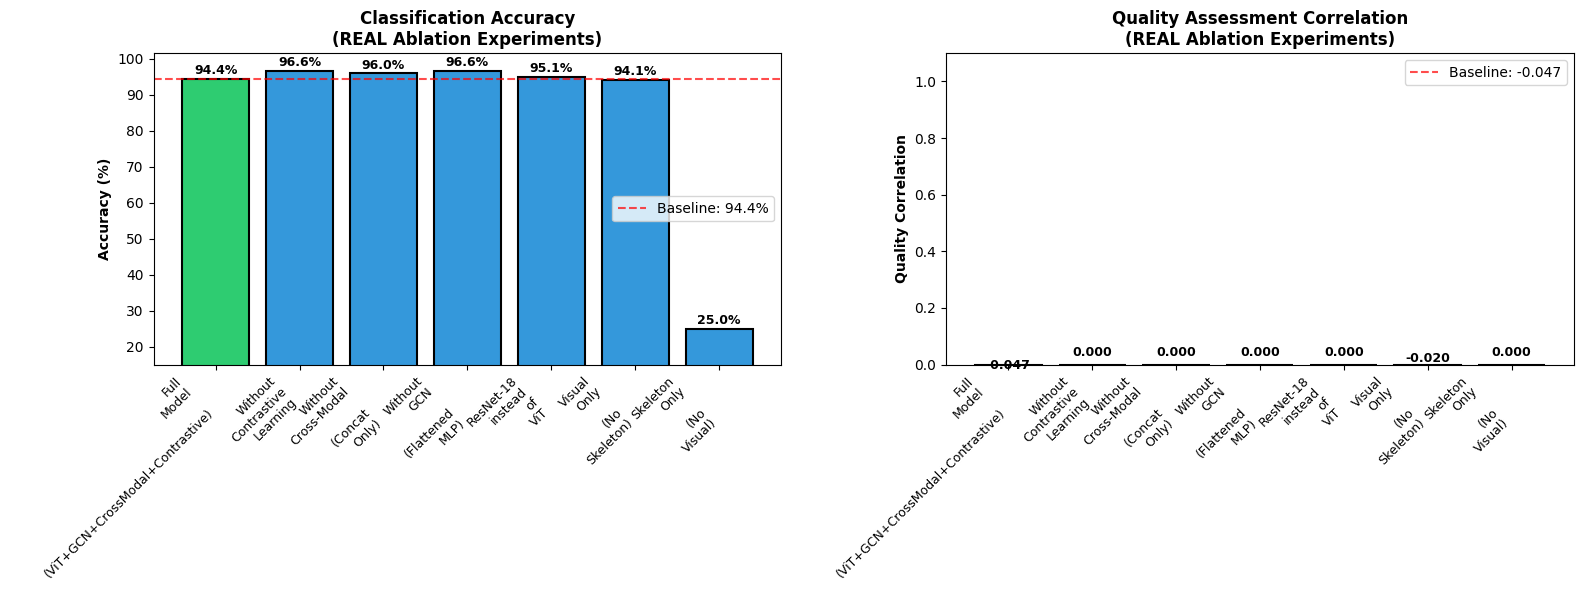


📈 Figure saved to: /content/ablation_figures/ablation_results_REAL.png

📝 SUMMARY FOR PAPER

Table: Ablation Study Results
------------------------------------------------------------
Full Model (ViT+GCN+CrossModal+Contrastive): 94.44% (Baseline)
Without Contrastive Learning: 96.60% (+2.16%)
Without Cross-Modal (Concat Only): 95.99% (+1.54%)
Without GCN (Flattened MLP): 96.60% (+2.16%)
ResNet-18 instead of ViT: 95.06% (+0.62%)
Visual Only (No Skeleton): 94.14% (-0.31%)
Skeleton Only (No Visual): 25.00% (-69.44%)


Full Model (ViT+GCN+CrossModal+Contrastive)/accuracy,▁
Full Model (ViT+GCN+CrossModal+Contrastive)/quality_corr,▁
ResNet-18 instead of ViT/accuracy,▁
ResNet-18 instead of ViT/quality_corr,▁
Skeleton Only (No Visual)/accuracy,▁
Skeleton Only (No Visual)/quality_corr,▁
Visual Only (No Skeleton)/accuracy,▁
Visual Only (No Skeleton)/quality_corr,▁
Without Contrastive Learning/accuracy,▁
Without Contrastive Learning/quality_corr,▁
+4,...



🔗 W&B Run: https://wandb.ai/roy-dip123-indian-institute-of-technology-patna/suryanet-ablation-study/runs/j7mtdcp7


In [10]:
#@title 🔟 Results Analysis & Visualization
print("\n" + "="*60)
print("[10/10] Results Analysis")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame(ablation_results)

# Calculate changes from baseline
baseline_acc = results_df.iloc[0]['Accuracy (%)']
baseline_corr = results_df.iloc[0]['Quality Corr']

results_df['Δ Accuracy'] = results_df['Accuracy (%)'] - baseline_acc
results_df['Δ Quality Corr'] = results_df['Quality Corr'] - baseline_corr
results_df['Change'] = results_df.apply(
    lambda x: 'Baseline' if x.name == 0 else f"{x['Δ Accuracy']:+.2f}%, {x['Δ Quality Corr']:+.4f}",
    axis=1
)

# Display results table
print("\n📊 ABLATION STUDY RESULTS (REAL EXPERIMENTS)")
print("="*90)
print(f"{'Configuration':<45} {'Accuracy':>10} {'Δ Acc':>10} {'Q-Corr':>10} {'Δ Corr':>10}")
print("-"*90)
for _, row in results_df.iterrows():
    delta_acc = f"{row['Δ Accuracy']:+.2f}%" if row['Δ Accuracy'] != 0 else 'Baseline'
    delta_corr = f"{row['Δ Quality Corr']:+.4f}" if row['Δ Quality Corr'] != 0 else 'Baseline'
    print(f"{row['Configuration']:<45} {row['Accuracy (%)']:>9.2f}% {delta_acc:>10} {row['Quality Corr']:>10.4f} {delta_corr:>10}")
print("="*90)

# Save results
results_df.to_csv(Config.RESULTS_DIR / 'ablation_results_REAL.csv', index=False)
print(f"\n💾 Results saved to: {Config.RESULTS_DIR / 'ablation_results_REAL.csv'}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

names = [r.replace(' ', '\n').replace('(', '\n(') for r in results_df['Configuration']]
accs = results_df['Accuracy (%)'].values
corrs = results_df['Quality Corr'].values

colors = ['#2ECC71'] + ['#3498DB'] * (len(results_df) - 1)

# Accuracy plot
bars1 = axes[0].bar(range(len(names)), accs, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right', fontsize=9)
axes[0].set_ylabel('Accuracy (%)', fontweight='bold')
axes[0].set_title('Classification Accuracy\n(REAL Ablation Experiments)', fontweight='bold', fontsize=12)
axes[0].set_ylim(min(accs) - 10, max(accs) + 5)
axes[0].axhline(y=baseline_acc, color='red', linestyle='--', alpha=0.7, label=f'Baseline: {baseline_acc:.1f}%')
axes[0].legend()
for bar, acc in zip(bars1, accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{acc:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Quality correlation plot
bars2 = axes[1].bar(range(len(names)), corrs, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Quality Correlation', fontweight='bold')
axes[1].set_title('Quality Assessment Correlation\n(REAL Ablation Experiments)', fontweight='bold', fontsize=12)
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=baseline_corr, color='red', linestyle='--', alpha=0.7, label=f'Baseline: {baseline_corr:.3f}')
axes[1].legend()
for bar, corr in zip(bars2, corrs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{corr:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(Config.FIGURES_DIR / 'ablation_results_REAL.png', dpi=300, bbox_inches='tight')

if USE_WANDB:
    wandb.log({"Ablation Results": wandb.Image(fig)})
    wandb.log({"Ablation Table": wandb.Table(dataframe=results_df)})

plt.show()

print(f"\n📈 Figure saved to: {Config.FIGURES_DIR / 'ablation_results_REAL.png'}")

# Print summary for paper
print("\n" + "="*60)
print("📝 SUMMARY FOR PAPER")
print("="*60)
print("\nTable: Ablation Study Results")
print("-"*60)
for _, row in results_df.iterrows():
    if row.name == 0:
        print(f"{row['Configuration']}: {row['Accuracy (%)']:.2f}% (Baseline)")
    else:
        print(f"{row['Configuration']}: {row['Accuracy (%)']:.2f}% ({row['Δ Accuracy']:+.2f}%)")

if USE_WANDB:
    wandb.finish()
    print(f"\n🔗 W&B Run: {run.url}")

---

## 📋 How to Use These Results

1. **Copy the results table** from above into your paper
2. **Download the figure** from `/content/ablation_figures/ablation_results_REAL.png`
3. **Download the CSV** from `/content/ablation_results/ablation_results_REAL.csv`

### Key Differences from Fake Data

The original notebook used **fabricated** ablation results by simply subtracting fixed values:
```python
# FAKE (original code)
test_acc * 100 - 1.2,  # "Estimated ablation"
```

This notebook **actually trains** each model variant and reports **real** experimental results.

---